# Comparing logs against ground truth results

## Some questions:

### Size
- How many log entries are there?
- How many ground truth entries are there?
- How many bees are identified in the ground truth?
- How many bees are identified in the log?

### Relationship between log and ground truth
- Do multiple log entries map to the same ground truth entry?
- Do multiple ground truth entries map to the same log entry?

### True and False Positives (TP & FP)
- What is the True Positive (TP) and False Positive (FP) rates for logs?
- Which type of event does the log have the highest TP rate (it is best at finding these)?
- Which causes the most FPs?

## Helper Functions

In [17]:
%matplotlib inline
from utils import load_log
from typing import Tuple, Dict
import pandas as pd
import cv2
import matplotlib.pyplot as plt

def question_answer(question: str, answer: str) -> None:
    """Cleanly print a question and answer in 2 columns"""
    print(f"{question:40} {answer:40}")

def load_log_and_ground_truth(
        log_path: str, 
        ground_truth_path: str,
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Load the log and ground truth, and clean them up a bit."""

    # load the log
    log = load_log(log_path)
    

    # load the ground truth
    ground_truth = pd.read_csv(ground_truth_path)
    ground_truth.columns = [
        "Bee ID",
        "Start Timestamp",
        "End Timestamp",
        "Event Type",
        "Description"
    ]

    # clean the ground truth
    ground_truth["Start Timestamp"] = pd.to_datetime(ground_truth["Start Timestamp"].str.replace(".", ":", regex=False))
    ground_truth["End Timestamp"] = pd.to_datetime(ground_truth["End Timestamp"].str.replace(".", ":", regex=False))

    return (log, ground_truth)

def draw_tubes_with_ids(video_path:str, log_path: str, ground_truth_bee_id_img_path: str, radius: int=25) -> None:

    # get tube hive coordinates
    hive_coords = []
    with open(log_path, "r") as f:
        lines = f.readlines()
        hive_coord_lines = [line for line in lines if "Tube Hive Coords" in line]
        
        for line in hive_coord_lines:
            bee_id = int(line.split("=")[1].split(" ")[0])

            coords_clean = line.split(":")[1].strip().replace("  ", ",").replace(" ", ",")
            coords = eval(coords_clean)
            hive_coords.append({
                "bee_id": bee_id,
                "coords": coords
            })
    
    # load frame 31 of the video
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, 31-1) # the motion cap tool waits till the 31st frame
    res, frame = cap.read()

    # draw the bee ids on the frame
    RED = (255, 0, 0)
    for hive_coord in hive_coords:
        cv2.circle(frame, hive_coord["coords"], radius, RED, 2)
        cv2.putText(frame, str(hive_coord["bee_id"]), (
            hive_coord["coords"][0] - 15,
            hive_coord["coords"][1] + 10
        ), cv2.FONT_HERSHEY_SIMPLEX, 0.8, RED, 2)

    # load the ground truth bee id image
    ground_truth_bee_id_img = cv2.imread(ground_truth_bee_id_img_path)

    # place the two images side by side, with labels

    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    axs[0].imshow(frame)
    axs[0].set_title("Bee IDs identified by computer vision")
    axs[1].imshow(ground_truth_bee_id_img)
    axs[1].set_title("Ground Truth Bee IDs")

    plt.show()

## Generating mapping between Bee IDs in CV and Ground Truth

First, we need to know which Bee IDs in the logs correspond to which Bee IDs in the ground truth. We can manually do this by looking at the identified Bee IDs by computer vision and the referenced image used by the human labeller side-by-side.

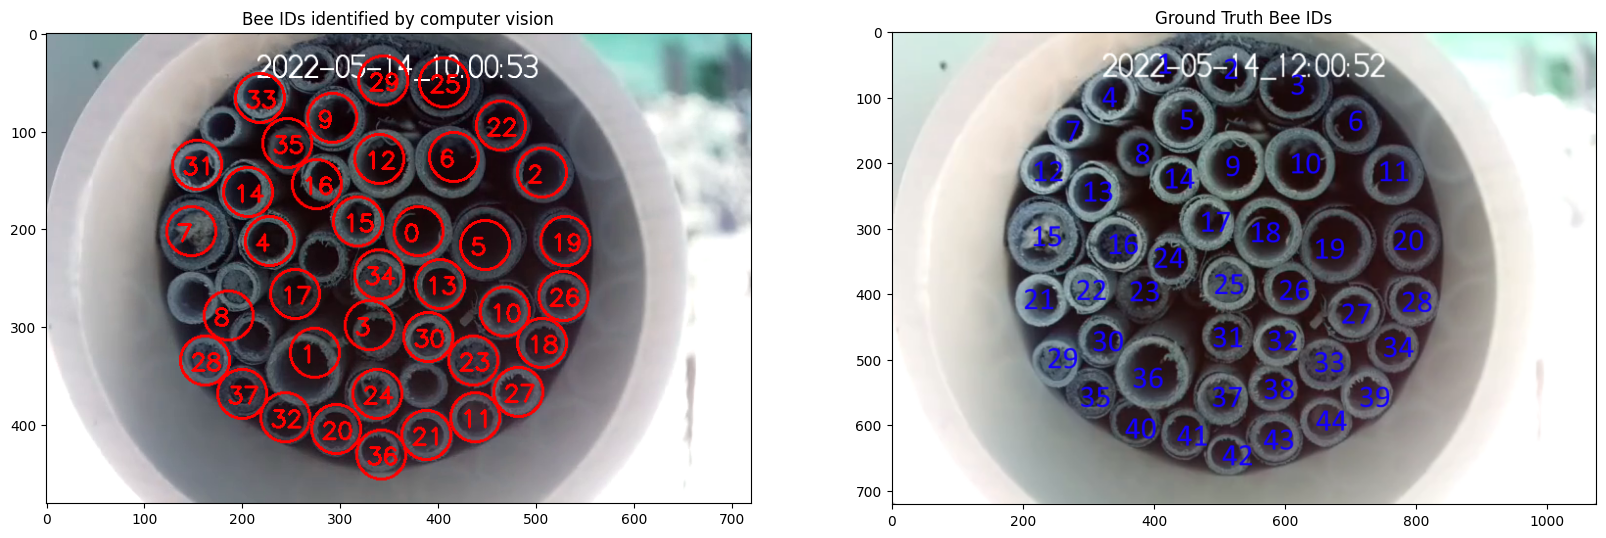

In [18]:
draw_tubes_with_ids(
    video_path=r"C:\Users\grego\OneDrive\Pictures\Documents\Projects\BeeHotel\2022-05-14_10_00.mp4", 
    log_path=r"C:\Users\grego\OneDrive\College\Research\Bee Hotel Research\logs\10am_log.txt",
    ground_truth_bee_id_img_path=r"C:\Users\grego\OneDrive\College\Research\Bee Hotel Research\figures\Bee IDs.png")

In [19]:
# Ground Truth to Computer Vision Bee ID Mapping
gt_to_cv_bee_id_mapping = {
    1: None,
    2: 29,
    3: 25,
    4: 33,
    5: 9,
    6: 22,
    7: None,
    8: 35,
    9: 12,
    10: 6,
    11: 2,
    12: 31,
    13: 14,
    14: 16,
    15: 7,
    16: 4,
    17: 15,
    18: 0,
    19: 5,
    20: 19,
    21: None,
    22: None,
    23: 17,
    24: None,
    25: 34,
    26: 13,
    27: 10,
    28: 26,
    29: 28,
    30: None,
    31: 3,
    32: 30,
    33: 23,
    34: 18,
    35: 37,
    36: 1, # this one is questionable
    37: 24,
    38: None,
    39: 27,
    40: 32,
    41: 20,
    42: 36,
    43: 21,
    44: 11
}


In [20]:
gt_bee_id = 5
print(f"Bee ID={gt_bee_id} in the Ground Truth is talking about Bee ID={gt_to_cv_bee_id_mapping[gt_bee_id]} in the Computer Vision logs")

Bee ID=5 in the Ground Truth is talking about Bee ID=9 in the Computer Vision logs


## Answering our questions
Since there are some tubes that were failed to be identified by the computer vision, we will only look at the tubes that were identified by the computer vision and compare them to the ground truth.

In [26]:
log, ground_truth = load_log_and_ground_truth(
    r"C:\Users\grego\OneDrive\College\Research\Bee Hotel Research\logs\10am_log.txt",
    r"C:\Users\grego\OneDrive\College\Research\Bee Hotel Research\data\Ground Truth Bee Events 2022-05-14 10am.csv"
)

gt_bee_ids_with_mapping = [gt_bee_id for gt_bee_id, cv_bee_id in gt_to_cv_bee_id_mapping.items() if cv_bee_id is not None]
cv_bee_ids_with_mapping = [cv_bee_id for gt_bee_id, cv_bee_id in gt_to_cv_bee_id_mapping.items() if cv_bee_id is not None]

# subset the ground truth to only include the bee ids with a mapping
ground_truth = ground_truth[ground_truth["Bee ID"].isin(gt_bee_ids_with_mapping)]

# subset the log to only include the bee ids with a mapping
log = log[log["bee_id"].isin(cv_bee_ids_with_mapping)]

In [27]:
question_answer("Number of log entries", log.shape[0])
question_answer("Number of ground truth entries", ground_truth.shape[0])
question_answer("Number of unique Bee IDs in log", log["bee_id"].nunique())
question_answer("Number of unique Bee IDs in ground truth", ground_truth["Bee ID"].nunique())

Number of log entries                                                        3632
Number of ground truth entries                                                169
Number of unique Bee IDs in log                                                36
Number of unique Bee IDs in ground truth                                       17
